In [1]:
import torch
import os

import numpy as np
import torch.nn as nn
import torch

from sklearn.metrics import f1_score
from matplotlib import colors, pyplot as plt
%matplotlib inline

from PIL import Image
from pathlib import Path

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import ReduceLROnPlateau


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
device=("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
data_dir = "/kaggle/input/animal-data/animal_data"

data_dir = Path(data_dir)

In [4]:
pictures = list(data_dir.glob('Bird/*'))
print(len(pictures))

137


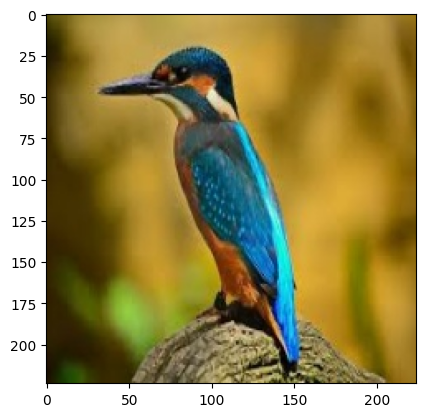

In [5]:
im = plt.imread('/kaggle/input/animal-data/animal_data/Bird/Bird_1.jpeg')
plt.imshow(im)
plt.show()

In [6]:
class Animals(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_to_idx = {}  # Словарь для хранения соответствия классов и их индексов

        # Загрузка списка файлов и меток
        for i, label_dir in enumerate(sorted(os.listdir(root_dir))):
            class_dir = os.path.join(root_dir, label_dir)
            self.class_to_idx[label_dir] = i
            for img_file in sorted(os.listdir(class_dir)):
                self.images.append(os.path.join(class_dir, img_file))
                self.labels.append(i)

    def get_class_to_idx(self):
        return self.class_to_idx

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [7]:
def create_splits(root_dir, train_transform, test_transform):
    # Создание датасета
    full_dataset = Animals(root_dir=root_dir) #, transform=train_transform)

    # Разделение данных
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

    # Применяем разные трансформации для валидации и тестирования
    train_data.dataset.transform = train_transform
    val_data.dataset.transform = test_transform
    test_data.dataset.transform = test_transform

    return train_data, val_data, test_data

In [8]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),         # Случайное горизонтальное отражение
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),  # Изменение яркости, контрастности, насыщенности и оттенка
    transforms.RandomGrayscale(p=0.2),         # С вероятностью 20% преобразовать изображение в оттенки серого
    transforms.ToTensor(),                     # Преобразование изображения в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])  # Нормализация
])


test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [9]:
train_data, val_data, test_data = create_splits('/kaggle/input/animal-data/animal_data', train_transform, test_transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=4)

full_dataset = Animals('/kaggle/input/animal-data/animal_data') 
class_to_idx = full_dataset.get_class_to_idx()

In [10]:
num_batches_train = len(train_loader)
num_batches_val = len(val_loader)
num_batches_test = len(test_loader)
num_batches_train, num_batches_val,num_batches_test

(85, 19, 19)

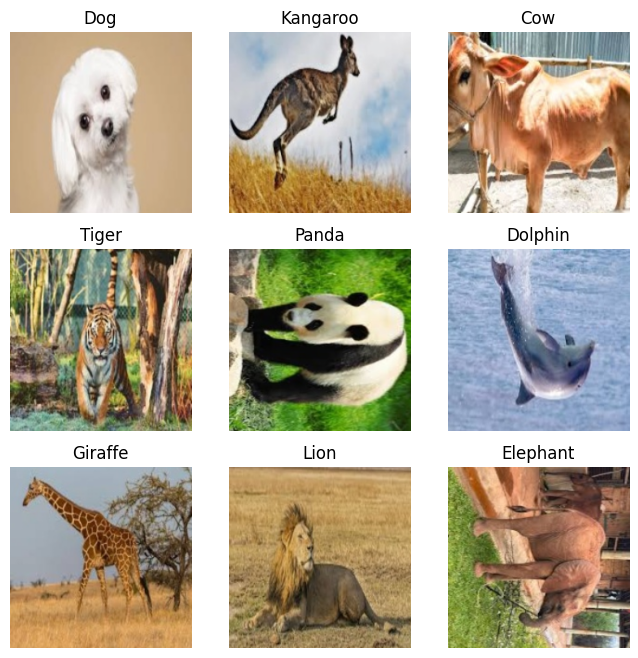

In [11]:
def imshow(inp, title=None, plt_ax=None):
    """Imshow для тензоров с использованием осей plt_ax."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # денормализация
    inp = np.clip(inp, 0, 1)
    if plt_ax is None:
        plt_ax = plt.gca()
    plt_ax.imshow(inp)
    plt_ax.axis('off')
    if title is not None:
        plt_ax.set_title(title)

def show_images_with_labels(val_loader, class_to_idx):
    """Отображает изображения и метки в сетке 3x3."""
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=True, sharex=True)

    # Получаем один батч данных
    images, labels = next(iter(val_loader))

    # Преобразование индексов в названия классов
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    for i, fig_x in enumerate(ax.flatten()):
        # Для демонстрации выбираем i-е изображение из батча
        im_val = images[i]
        label = labels[i]
        img_label = idx_to_class[label.item()]  # Получение названия класса по метке

        imshow(im_val, title=img_label, plt_ax=fig_x)

    plt.show()

show_images_with_labels(val_loader, class_to_idx)


In [12]:
def check_labels(dataloader, class_to_idx):
    labels_list = []

    for _, labels in dataloader:
        if isinstance(labels, torch.Tensor):
            labels_list.extend(labels.tolist())
        else:
            labels_list.extend(labels)

    labels_array = np.array(labels_list)
    unique_labels, counts = np.unique(labels_array, return_counts=True)

    # Преобразование индексов в названия классов
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    class_names = [idx_to_class[label] for label in unique_labels]

    print("Уникальные метки классов:", class_names)
    print("Количество каждой метки:", counts)

    return unique_labels, counts


unique_labels, counts = check_labels(train_loader, class_to_idx)

Уникальные метки классов: ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']
Количество каждой метки: [ 84 101  89  97  89  86  84  89 100  92  84  92  96  85  92]


In [13]:
unique_labels, counts = check_labels(val_loader, class_to_idx)

Уникальные метки классов: ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']
Количество каждой метки: [17 18 15 17 19 17 24 30 13 18 22 18 23 21 19]


In [14]:
unique_labels, counts = check_labels(test_loader, class_to_idx)

Уникальные метки классов: ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']
Количество каждой метки: [24 18 19 17 19 19 21 14 16 20 20 21 16 23 26]


In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total

        # Валидация модели
        val_loss, val_acc = validate_model(model, val_loader, criterion, device)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        # Шаг планировщика по уменьшению lr
        scheduler.step(val_loss)

    torch.cuda.empty_cache()


In [16]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / total
    val_acc = correct / total
    return val_loss, val_acc

In [17]:
def predict(model, dataloader, device):
    model.eval()  # Переводим модель в режим оценки
    predictions = []

    with torch.no_grad():  # Отключаем вычисление градиентов
        for images in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Получаем предсказанные классы
            predictions.extend(predicted.cpu().numpy())  # Сохраняем предсказания

    return predictions


In [18]:
def create_model(num_classes):
    # Загрузка предобученной модели VGG16
    model = models.vgg16(pretrained=True)
    
    # Заморозка весов модели
    for param in model.parameters():
        param.requires_grad = False
    
    # Получение количества входных признаков на последнем слое
    num_features = model.classifier[6].in_features
    
    # Замена последнего слоя на новый, который соответствует количеству классов
    model.classifier[6] = nn.Linear(num_features, 15)
    
    return model


In [19]:
model_vgg = create_model(15).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_vgg.parameters(), lr=0.01, momentum=0.9)

train_model(model_vgg, train_loader, val_loader, criterion,
            optimizer, num_epochs=20)

Epoch [1/20], Loss: 0.6721, Accuracy: 0.8169, Val Loss: 0.4451, Val Accuracy: 0.9107
Epoch [2/20], Loss: 0.2902, Accuracy: 0.9221, Val Loss: 0.3850, Val Accuracy: 0.9141
Epoch [3/20], Loss: 0.1609, Accuracy: 0.9529, Val Loss: 0.4346, Val Accuracy: 0.9175
Epoch [4/20], Loss: 0.1344, Accuracy: 0.9610, Val Loss: 0.2904, Val Accuracy: 0.9416
Epoch [5/20], Loss: 0.1151, Accuracy: 0.9669, Val Loss: 0.1736, Val Accuracy: 0.9416
Epoch [6/20], Loss: 0.1176, Accuracy: 0.9684, Val Loss: 0.1584, Val Accuracy: 0.9588
Epoch [7/20], Loss: 0.0669, Accuracy: 0.9779, Val Loss: 0.2766, Val Accuracy: 0.9381
Epoch [8/20], Loss: 0.0901, Accuracy: 0.9779, Val Loss: 0.2479, Val Accuracy: 0.9450
Epoch [9/20], Loss: 0.0628, Accuracy: 0.9801, Val Loss: 0.1990, Val Accuracy: 0.9450
Epoch 00009: reducing learning rate of group 0 to 1.0000e-03.
Epoch [10/20], Loss: 0.0485, Accuracy: 0.9890, Val Loss: 0.2067, Val Accuracy: 0.9450
Epoch [11/20], Loss: 0.0388, Accuracy: 0.9860, Val Loss: 0.2041, Val Accuracy: 0.9485
E

In [21]:
model = models.resnet50(pretrained=True)

# Замораживаем параметры (веса) всех слоёв модели
for param in model.parameters():
    param.requires_grad = False

# Изменение последнего слоя для классификации на 15 классов
num_features = model.fc.in_features  # Получаем количество входных фичей последнего слоя
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, num_features),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(num_features, num_features),
    nn.ReLU(),
    nn.Linear(num_features, 15)
) 

print(model)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_model(model, train_loader, val_loader, criterion,
            optimizer, num_epochs=15)

Epoch [1/15], Loss: 2.0512, Accuracy: 0.3794, Val Loss: 0.7327, Val Accuracy: 0.8041
Epoch [2/15], Loss: 0.7300, Accuracy: 0.7779, Val Loss: 0.3884, Val Accuracy: 0.8866
Epoch [3/15], Loss: 0.5770, Accuracy: 0.8059, Val Loss: 0.2578, Val Accuracy: 0.9038
Epoch [4/15], Loss: 0.5403, Accuracy: 0.8243, Val Loss: 0.1802, Val Accuracy: 0.9450
Epoch [5/15], Loss: 0.4707, Accuracy: 0.8574, Val Loss: 0.2182, Val Accuracy: 0.9347
Epoch [6/15], Loss: 0.3969, Accuracy: 0.8728, Val Loss: 0.1864, Val Accuracy: 0.9347
Epoch [7/15], Loss: 0.3151, Accuracy: 0.8985, Val Loss: 0.1888, Val Accuracy: 0.9347
Epoch 00007: reducing learning rate of group 0 to 1.0000e-03.
Epoch [8/15], Loss: 0.2126, Accuracy: 0.9265, Val Loss: 0.1080, Val Accuracy: 0.9691
Epoch [9/15], Loss: 0.1814, Accuracy: 0.9434, Val Loss: 0.1011, Val Accuracy: 0.9691
Epoch [10/15], Loss: 0.1503, Accuracy: 0.9544, Val Loss: 0.0986, Val Accuracy: 0.9656
Epoch [11/15], Loss: 0.1560, Accuracy: 0.9463, Val Loss: 0.1098, Val Accuracy: 0.9656
E

In [23]:
def predict(model, dataloader, device):
    model.eval()  # Переводим модель в режим оценки
    predictions = []

    with torch.no_grad():  # Отключаем вычисление градиентов
        for images, _ in dataloader:  # Добавляем _ для меток, которые не используются
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Получаем предсказанные классы
            predictions.extend(predicted.cpu().numpy())  # Сохраняем предсказания

    return predictions


In [24]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

all_labels = []
for _, labels in test_loader:
    all_labels.extend(labels.tolist())  # Добавляем метки текущего батча в список

In [25]:
pred = predict(model, test_loader, device)

f1_score(all_labels, pred, average='micro')


0.9692832764505119

In [26]:
def accuracy_by_category(model, dataloader, device, class_to_idx):
    model.eval()  # Переключаем модель в режим оценки
    category_correct = {}
    category_total = {}

    # Преобразование индексов в названия классов
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    with torch.no_grad():  # Отключаем вычисление градиентов
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).squeeze()
            
            for i in range(len(labels)):
                label = labels[i].item()
                correct_pred = correct[i].item()
                label_name = idx_to_class[label]  # Получение названия класса
                if label_name not in category_correct:
                    category_correct[label_name] = 0
                    category_total[label_name] = 0
                category_correct[label_name] += correct_pred
                category_total[label_name] += 1

    # Вывод результатов по категориям
    for category, correct_count in category_correct.items():
        total = category_total[category]
        accuracy = 100 * correct_count / total
        print(f'{category}: Правильных ответов {accuracy:.2f}% ({correct_count}/{total})')

accuracy_by_category(model, test_loader, device, class_to_idx)


Elephant: Правильных ответов 100.00% (14/14)
Horse: Правильных ответов 100.00% (20/20)
Kangaroo: Правильных ответов 85.00% (17/20)
Bird: Правильных ответов 100.00% (18/18)
Deer: Правильных ответов 78.95% (15/19)
Cat: Правильных ответов 100.00% (19/19)
Dolphin: Правильных ответов 100.00% (21/21)
Cow: Правильных ответов 94.12% (16/17)
Tiger: Правильных ответов 100.00% (23/23)
Zebra: Правильных ответов 100.00% (26/26)
Panda: Правильных ответов 100.00% (16/16)
Giraffe: Правильных ответов 100.00% (16/16)
Bear: Правильных ответов 100.00% (24/24)
Dog: Правильных ответов 100.00% (19/19)
Lion: Правильных ответов 95.24% (20/21)
